<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Лозовой Виталий Витальевич

## <center> Прогнозирование ориентации по анкете на сайте знакомств </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы


In [169]:
import time, os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, accuracy_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, validation_curve, learning_curve
from scipy.sparse import csr_matrix, hstack
import catboost

import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline

# константа для задания размеров графиков
FIGSIZE_TUPLE = (12, 9)

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,      
    rc = { 
        "figure.figsize" : FIGSIZE_TUPLE, 
        "axes.titlesize" : 18 
    }
)

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':FIGSIZE_TUPLE})
from matplotlib import rcParams
rcParams['figure.figsize'] = FIGSIZE_TUPLE

import warnings
warnings.filterwarnings('ignore')

###  Часть 1. Описание набора данных и признаков

Ссылка на скачивание https://github.com/rudeboybert/JSE_OkCupid/raw/master/profiles.csv.zip

Название датасета: San Francisco OKCupid Users
Размер: таблица на 59946 анкет (пользователей, активных на 30.06.2012), 31 переменная

Описание: Датасет создан скриптом, собирающим данные открытых публичных профилей на www.okcupid.com. 59946 анкет пользователей живущих в радиусе не более 25 миль от Сан Франциско, которые были онлайн в течении года (с 30.06.2011), с хотя бы одной фотографией.
Разрешение на использование данных получено у президента и сооснователя OkCupid - Christian Rudder.

Описание переменных:
Некоторые столбцы могут иметь 2 значения. В таких случаях значения разделяются точкой с запятой (например "graduated from; two-year college").

Столбцы:

| Столбец | Пояснение, тип | Значения |
|:---------:|:------:| ----------- |
| age | Возраст, чисельный | Значение в годах |
| body_type | Телосложение, категориальный | rather not say, thin, overweight, skinny, average, fit, athletic, jacked, a little extra, curvy, full figured, used up |
| diet | Диета, категориальный | mostly/strictly; anything, vegetarian, vegan, kosher, halal, other |
| drinks | Отношение к алкоголю, категориальный | very often, often, socially, rarely, desperately, not at all |
| drugs | Употребление веществ, категориальный | never, sometimes, often |
| education | Образование, категориальный, может иметь несколько значений | graduated from, working on, dropped out of; high school, two-year college, university, masters program, law school, med school, Ph.D program, space camp |
| ethnicity | Происхождение | Asian, middle eastern, black, native American, indian, pacific islander, Hispanic/latin, white, other |
| height | Рост, чисельный | Значение задано в дюймах |
| income | Доход, как не странно - категориальный. Задан в US $, -1 значит "лучше даже не говорить" | -1, 20000, 30000, 40000, 50000, 60000 70000, 80000, 100000, 150000, 250000, 500000, 1000000 |
| job | Род деятельности, категориальный | student, art/music/writing, banking/finance, administration, technology, construction, education, entertainment/media, management, hospitality, law, medicine, military, politics/government, sales/marketing, science/engineering, transportation, unemployed, other, rather not say, retire |
| last_online | Дата и время последнего посещения, строка | Дата в формате ГГГГ-ММ-ДД-ЧЧ-мм |
| offspring | Наличие/отношение к детям. Может иметь 2 значения | has a kid, has kids, doesnt have a kid, doesn't want kids; ,and/,but might want them, wants them, doesnt want any, doesnt want more |
| orientation | Сексуальная ориентация, категориальный | straight, gay, bisexual |
| pets | Коты, собаки и отношение к ним - может иметь 2 значения | has dogs, likes dogs, dislikes dogs; and has cats, likes cats, dislikes cats |
| religion | Религия и отношение к ней, категориальный, может иметь 2 значения | agnosticism, atheism, Christianity, Judaism, Catholicism, Islam, Hinduism, Buddhism, Other; and very serious about it, and somewhat serious about it, but not too serious about it, and laughing about it |
| sex | Пол, бинарный | m, f |
| sign | Знак зодиака и отношение к нему, категориальный, может иметь 2 значения | aquarius, pices, aries, Taurus, Gemini, cancer, leo, virgo, libra, scorpio, saggitarius, Capricorn; but it doesn’t matter, and it matters a lot, and it’s fun to think about |
| smokes | Курение, категориальный | yes, sometimes, when drinking, trying to quit, no |
| speaks | Языки, категориальный, может иметь много значений | English (fluently, okay, poorly). Afrikaans, Albanian, Arabic, Armenian, Basque, Belarusan, Bengali, Breton, Bulgarian, Catalan, Cebuano, Chechen, Chinese, C++, Croatian, Czech, Danish, Dutch, Esperanto, Estonian, Farsi, Finnish, French, Frisian, Georgian, German, Greek, Gujarati, Ancient Greek, Hawaiian, Hebrew, Hindi, Hungarian, Icelandic, Ilongo, Indonesian, Irish, Italian, Japanese, Khmer, Korean, Latin, Latvian, LISP, Lithuanian, Malay, Maori, Mongolian, Norwegian, Occitan, Other, Persian, Polish, Portuguese, Romanian, Rotuman, Russian, Sanskrit, Sardinian, Serbian, Sign Language, Slovak, Slovenian, Spanish, Swahili, Swedish, Tagalog, Tamil, Thai, Tibetan, Turkish, Ukranian, Urdu, Vietnamese, Welsh, Yiddish (fluently, okay, poorly) |
| status | Семейное положение, категориальный | single, seeing someone, married, in an open relationship |

Есть еще набор текстовых полей - essay0-9

  - essay0 - "My self summary" - кратко о себе
  - essay1 - "What I’m doing with my life" - чем я занимаюсь
  - essay2 - "I’m really good at" - что я делаю хорошо
  - essay3 - "The first thing people usually notice about me" - первое впечатление
  - essay4 - "Favorite books, movies, show, music, and food" - любимые продукты массовой культуры
  - essay5 - "The six things I could never do without" - вещи без которых я не могу обойтись
  - essay6 - "I spend a lot of time thinking about" - много думаю о ...
  - essay7 - "On a typical Friday night I am" - как я отдыхаю
  - essay8 - "The most private thing I am willing to admit" - что-то личное что я могу отметить
  - essay9 - "You should message me if..." - напиши мне если ...


In [170]:
data = pd.read_csv("../../data/okcupid_profiles.csv")
data.shape

(59946, 31)

###  Часть 2. Первичный анализ признаков

In [171]:
# Взглянем на столбцы
data.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [172]:
# Как выглядят даные?
data.head().T

,0,1,2,3,4
age,22,35,38,23,29
body_type,a little extra,average,thin,thin,athletic
diet,strictly anything,mostly other,anything,vegetarian,NaN
drinks,socially,often,socially,socially,socially
drugs,never,sometimes,NaN,NaN,never
education,working on college/university,working on space camp,graduated from masters program,working on college/university,graduated from college/university
essay0,about me:<br />\n<br />\ni would love to think...,i am a chef: this is what that means.<br />\n1...,"i'm not ashamed of much, but writing public te...",i work in a library and go to school. . .,hey how's it going? currently vague on the pro...
essay1,currently working as an international agent fo...,dedicating everyday to being an unbelievable b...,"i make nerdy software for musicians, artists, ...",reading things written by old dead people,work work work work + play
essay2,making people laugh.<br />\nranting about a go...,being silly. having ridiculous amonts of fun w...,improvising in different contexts. alternating...,playing synthesizers and organizing books acco...,creating imagery to look at:<br />\nhttp://bag...
essay3,"the way i look. i am a six foot half asian, ha...",NaN,my large jaw and large glasses are the physica...,socially awkward but i do my best,i smile a lot and my inquisitive nature


In [173]:
# Очень важно знать заполненьость даных
(data.count()/data.shape[0] * 100).sort_values(ascending=False).map('{:,.2f}'.format)

status         100.00
orientation    100.00
income         100.00
last_online    100.00
location       100.00
age            100.00
sex            100.00
height          99.99
speaks          99.92
drinks          95.02
body_type       91.17
essay0          90.85
smokes          90.81
ethnicity       90.52
education       88.94
essay1          87.37
job             86.32
essay2          83.92
essay4          82.42
essay5          81.90
sign            81.56
essay3          80.86
essay7          79.23
essay9          78.98
essay6          77.03
drugs           76.51
essay8          67.93
pets            66.77
religion        66.26
diet            59.31
offspring       40.68
dtype: object

Как видим - 4 поля, видимо, являются обязательными, last_online и location заполнялся парсером поетому заполнены на 100%. Категории достаточно подробно описаны, поетому посмотрим как выглядят столбцы, где можно выбрать несколько значений, и распределения роста и возраста

In [174]:
data[['height', 'age']].describe()

,height,age
count,59943.000000,59946.000000
mean,68.295281,32.340290
std,3.994803,9.452779
min,1.000000,18.000000
25%,66.000000,26.000000
50%,68.000000,30.000000
75%,71.000000,37.000000
max,95.000000,110.000000


Рост задан в дюймах и, как можно видеть, даные не очень чистые - есть и дюймовочка, и 2.5-метровый человек. По возрасту так-же есть выбросы, обработаем выбросы, и посмотрим как выглядит наш целевой признак <b>ориентация</b>

In [175]:
ct = pd.crosstab(data['sex'], data['orientation'], margins=True)
ct

orientation,bisexual,gay,straight,All
sex,,,,
f,1996,1588,20533,24117
m,771,3985,31073,35829
All,2767,5573,51606,59946


Теперь то же самое, но в процентном соотношении

In [176]:
ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100

orientation,bisexual,gay,straight
sex,,,
f,8.276320,6.584567,85.139113
m,2.151888,11.122275,86.725837
All,4.615821,9.296700,86.087479


In [177]:
data['diet'].unique()

array(['strictly anything', 'mostly other', 'anything', 'vegetarian', nan,
       'mostly anything', 'mostly vegetarian', 'strictly vegan',
       'strictly vegetarian', 'mostly vegan', 'strictly other',
       'mostly halal', 'other', 'vegan', 'mostly kosher',
       'strictly halal', 'halal', 'strictly kosher', 'kosher'],
      dtype=object)

Пока все просто - гастрономические предпочтения заданы категорией и "насколько строга диета" - `<strictly|normal|mostly>`. Разобъем диету на 2 колонки и заполним пробелы модой

In [178]:
def diet_transformer(x):
  if type(x) != list:
    return [None, None]
  if len(x) == 1:
    x.append('default')
    return x
  else:
    return x[::-1]
spltd = data['diet'].str.split(' ', 2).transform(diet_transformer)
spltd = pd.DataFrame(spltd.tolist(), columns=['diet_kind', 'diet_strenght'])
data['diet_kind'] = spltd['diet_kind'].fillna(spltd['diet_kind'].mode().values[0])
data['diet_strenght'] = spltd['diet_strenght'].fillna(spltd['diet_strenght'].mode().values[0])
data['diet_kind'].unique(), data['diet_strenght'].unique()

(array(['anything', 'other', 'vegetarian', 'vegan', 'halal', 'kosher'],
       dtype=object), array(['strictly', 'mostly', 'default'], dtype=object))

In [179]:
data['education'].unique()

array(['working on college/university', 'working on space camp',
       'graduated from masters program',
       'graduated from college/university', 'working on two-year college',
       nan, 'graduated from high school', 'working on masters program',
       'graduated from space camp', 'college/university',
       'dropped out of space camp', 'graduated from ph.d program',
       'graduated from law school', 'working on ph.d program',
       'two-year college', 'graduated from two-year college',
       'working on med school', 'dropped out of college/university',
       'space camp', 'graduated from med school',
       'dropped out of high school', 'working on high school',
       'masters program', 'dropped out of ph.d program',
       'dropped out of two-year college', 'dropped out of med school',
       'high school', 'working on law school', 'law school',
       'dropped out of masters program', 'ph.d program',
       'dropped out of law school', 'med school'], dtype=object)

In [180]:
data['ethnicity'].unique()

array(['asian, white', 'white', nan, 'asian, black, other',
       'white, other', 'hispanic / latin, white', 'hispanic / latin',
       'pacific islander, white', 'asian', 'black, white',
       'pacific islander', 'asian, native american',
       'asian, pacific islander', 'black, native american, white',
       'middle eastern, other', 'native american, white', 'indian',
       'black', 'black, native american, hispanic / latin, other',
       'black, native american, hispanic / latin',
       'asian, black, pacific islander',
       'asian, middle eastern, black, native american, indian, pacific islander, hispanic / latin, white, other',
       'other', 'hispanic / latin, other', 'asian, black',
       'middle eastern, white', 'native american, white, other',
       'black, native american', 'black, white, other',
       'hispanic / latin, white, other', 'middle eastern', 'black, other',
       'native american, hispanic / latin, white', 'black, indian',
       'indian, white, othe

Судя по ответам сродни **'asian, black, native american, pacific islander, white'** фича `etnicity` анализировать будет сложно

In [181]:
data['religion'].unique()

array(['agnosticism and very serious about it',
       'agnosticism but not too serious about it', nan, 'atheism',
       'christianity', 'christianity but not too serious about it',
       'atheism and laughing about it',
       'christianity and very serious about it', 'other', 'catholicism',
       'catholicism but not too serious about it',
       'catholicism and somewhat serious about it',
       'agnosticism and somewhat serious about it',
       'catholicism and laughing about it',
       'agnosticism and laughing about it', 'agnosticism',
       'atheism and somewhat serious about it',
       'buddhism but not too serious about it',
       'other but not too serious about it', 'buddhism',
       'other and laughing about it',
       'judaism but not too serious about it',
       'buddhism and laughing about it',
       'other and somewhat serious about it',
       'other and very serious about it',
       'hinduism but not too serious about it',
       'atheism but not too ser

Очень много вариантов, попробуем разбить на 2 признака - религия, отношение к религии

In [182]:
spltd = data['religion'].str.split(' ', 1).transform(lambda x: [None, None] if type(x) != list else x)
data = pd.concat([data, pd.DataFrame(spltd.tolist(), columns=['religion_confession', 'religion_respect'])], axis=1)
data['religion_confession'].unique(), data['religion_respect'].unique()

(array(['agnosticism', None, 'atheism', 'christianity', 'other',
        'catholicism', 'buddhism', 'judaism', 'hinduism', 'islam'],
       dtype=object),
 array(['and very serious about it', 'but not too serious about it', None,
        'and laughing about it', 'and somewhat serious about it'],
       dtype=object))

In [183]:
data['offspring'].unique()

array(['doesn&rsquo;t have kids, but might want them', nan,
       'doesn&rsquo;t want kids',
       'doesn&rsquo;t have kids, but wants them',
       'doesn&rsquo;t have kids', 'wants kids', 'has a kid', 'has kids',
       'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
       'has kids, but doesn&rsquo;t want more',
       'has a kid, but doesn&rsquo;t want more',
       'has a kid, and wants more', 'has kids, and might want more',
       'might want kids', 'has a kid, and might want more',
       'has kids, and wants more'], dtype=object)

Признак состоит по сути из двух - категории "есть ребенок/дети/нет детей" и категории "хочу/возможно захочу/не хочу". Разделим его в 2 столбца

In [184]:
def child_presense_transformer(x):
  if type(x) == float: #it's a NaN, handle it later
    return x
  elif x.startswith('has kids'):
    return 'multiple'
  elif x.startswith('has a kid'):
    return 'one'
  else:
    return 'no'
  
def want_child_transformer(x):
  if type(x) == float: #it's a NaN, handle it later
    return x
  elif 'wants' in x:
    return 'yes'
  elif 'doesn&rsquo;t want' in x:
    return 'no'
  else:
    return 'maybe'
  
data['has_kids'] = data['offspring'].apply(child_presense_transformer)
data['has_kids'].fillna(data['has_kids'].mode().values[0], inplace=True)
data['want_kids'] = data['offspring'].apply(want_child_transformer)
data['want_kids'].fillna(data['want_kids'].mode().values[0], inplace=True)

In [185]:
data[['has_kids', 'want_kids']].head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
has_kids,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
want_kids,maybe,maybe,maybe,no,maybe,maybe,maybe,yes,maybe,maybe,maybe,maybe,maybe,maybe,yes


In [186]:
data['sign'].unique()

array(['gemini', 'cancer', 'pisces but it doesn&rsquo;t matter', 'pisces',
       'aquarius', 'taurus', 'virgo', 'sagittarius',
       'gemini but it doesn&rsquo;t matter',
       'cancer but it doesn&rsquo;t matter',
       'leo but it doesn&rsquo;t matter', nan,
       'aquarius but it doesn&rsquo;t matter',
       'aries and it&rsquo;s fun to think about',
       'libra but it doesn&rsquo;t matter',
       'pisces and it&rsquo;s fun to think about', 'libra',
       'taurus but it doesn&rsquo;t matter',
       'sagittarius but it doesn&rsquo;t matter',
       'scorpio and it matters a lot',
       'gemini and it&rsquo;s fun to think about',
       'leo and it&rsquo;s fun to think about',
       'cancer and it&rsquo;s fun to think about',
       'libra and it&rsquo;s fun to think about',
       'aquarius and it&rsquo;s fun to think about',
       'virgo but it doesn&rsquo;t matter',
       'scorpio and it&rsquo;s fun to think about',
       'capricorn but it doesn&rsquo;t matter', 'sc

In [187]:
# def transform_
spltd = data['sign'].str.split(' ', 1).transform(lambda x: [None, None] if type(x) != list else x)
spltd = pd.DataFrame(spltd.tolist(), columns=['sign', 'astrology_respect']).fillna('not set')
data['sign'] = spltd['sign']
data['astrology_respect'] = spltd['astrology_respect']

In [188]:
data['pets'].unique()

array(['likes dogs and likes cats', 'has cats', 'likes cats', nan,
       'has dogs and likes cats', 'likes dogs and has cats',
       'likes dogs and dislikes cats', 'has dogs',
       'has dogs and dislikes cats', 'likes dogs',
       'has dogs and has cats', 'dislikes dogs and has cats',
       'dislikes dogs and dislikes cats', 'dislikes cats',
       'dislikes dogs and likes cats', 'dislikes dogs'], dtype=object)

Разобъем колонку на 2 одтельных для котов и собак

In [189]:
cats_relations = ['has cats', 'likes cats', 'dislikes cats']
dogs_relations = ['has dogs', 'likes dogs', 'dislikes dogs']
data['pets'].fillna('not set', inplace=True)
data['cats_relation'] = None
data['dogs_relation'] = None
for r in cats_relations:
  data['cats_relation'][data['pets'].str.contains(r)] = r
for r in dogs_relations:
  data['dogs_relation'][data['pets'].str.contains(r)] = r
  
data[['cats_relation', 'dogs_relation']] = data[['cats_relation', 'dogs_relation']].fillna('not set')
data[['cats_relation', 'dogs_relation']].head()

,cats_relation,dogs_relation
0,likes cats,likes dogs
1,likes cats,likes dogs
2,has cats,not set
3,likes cats,not set
4,likes cats,likes dogs


###  Часть 3. Первичный визуальный анализ признаков

Здесь мы будем смотреть распределения и чистить выбросы в чисельных данных. Учитывая отношение социума к нашему таргету - возможно большое колличество выбросов как раз и будет таргетом (чтоб лишний раз не попадать в поиск). Проверим гипотезу в конце

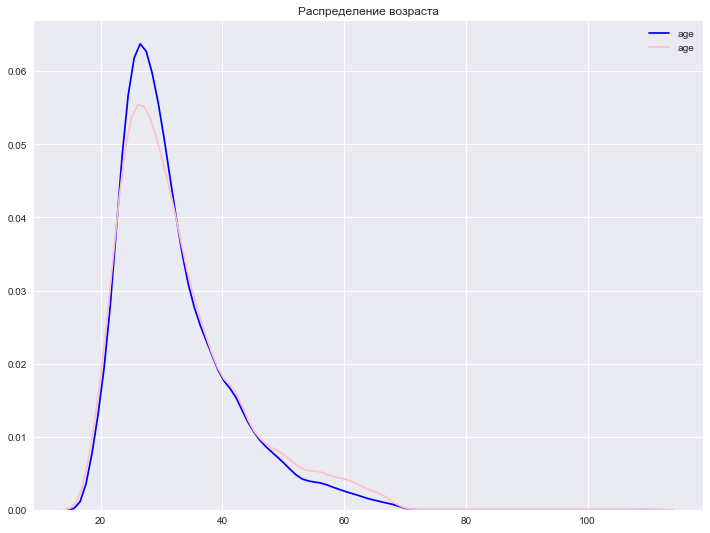

In [190]:
# Посмотрим распределение чисельных данных
sns.kdeplot(data[data['sex'] == 'm']['age'], color='blue').set_title('Распределение возраста')
sns.kdeplot(data[data['sex'] == 'f']['age'], color='pink');

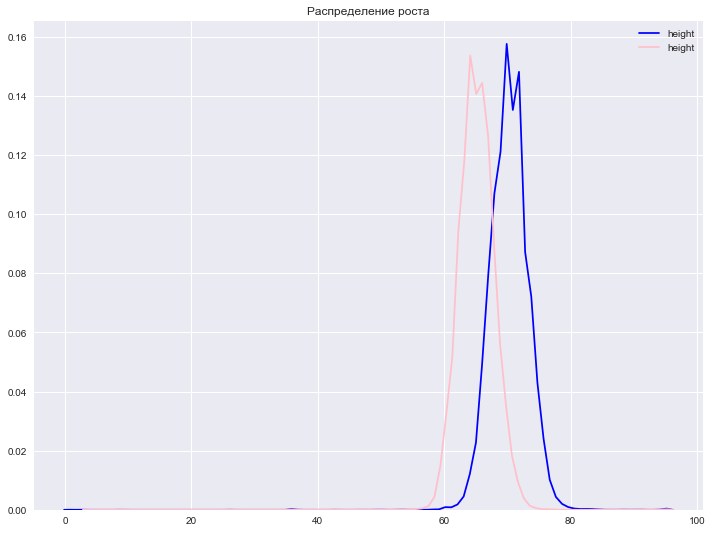

In [191]:
sns.kdeplot(data[data['sex'] == 'm']['height'].dropna(), color='blue').set_title('Распределение роста')
sns.kdeplot(data[data['sex'] == 'f']['height'].dropna(), color='pink');

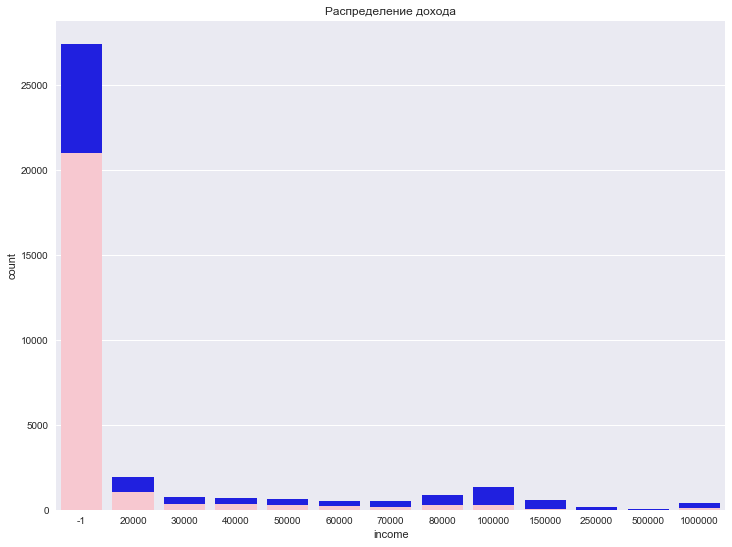

In [192]:
sns.countplot(data[data['sex'] == 'm']['income'].dropna(), color='blue').set_title('Распределение дохода')
sns.countplot(data[data['sex'] == 'f']['income'].dropna(), color='pink');

Как видно из графика - большинство респондентов не желает разглашать свой доход

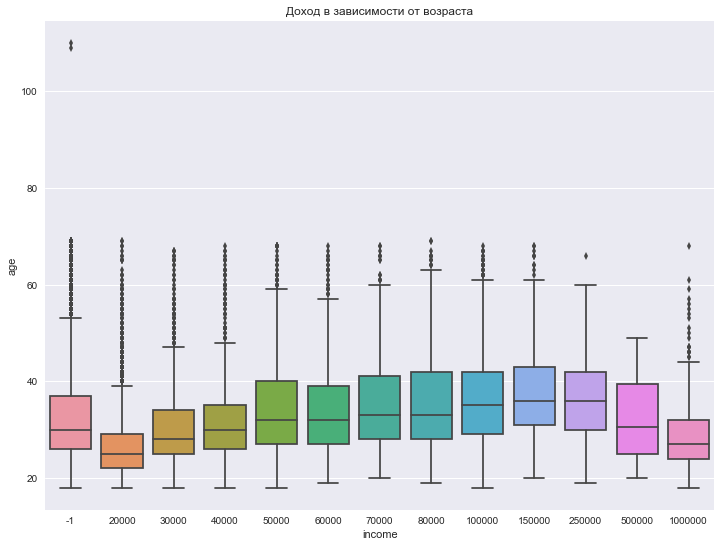

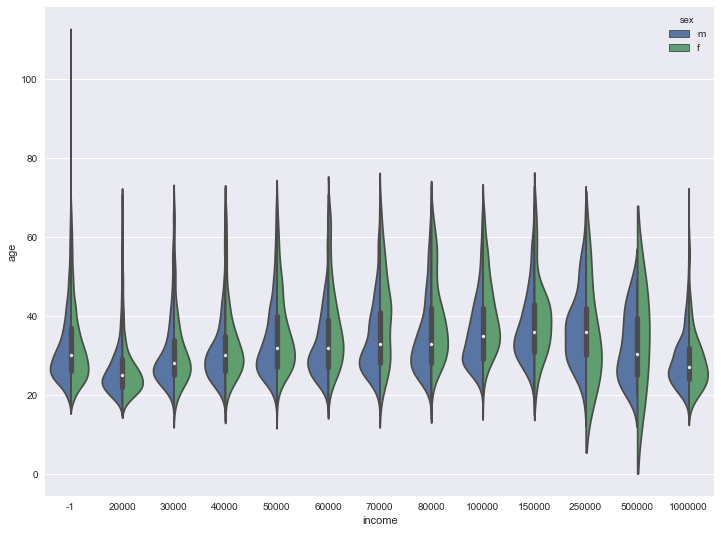

In [193]:
sns.boxplot(data['income'], data['age']).set_title('Доход в зависимости от возраста')
plt.show()
sns.violinplot(data=data, x='income', y='age', hue='sex', split=True);

Проверим стереотип о том что богатые пользуются популярностью у противоположного пола

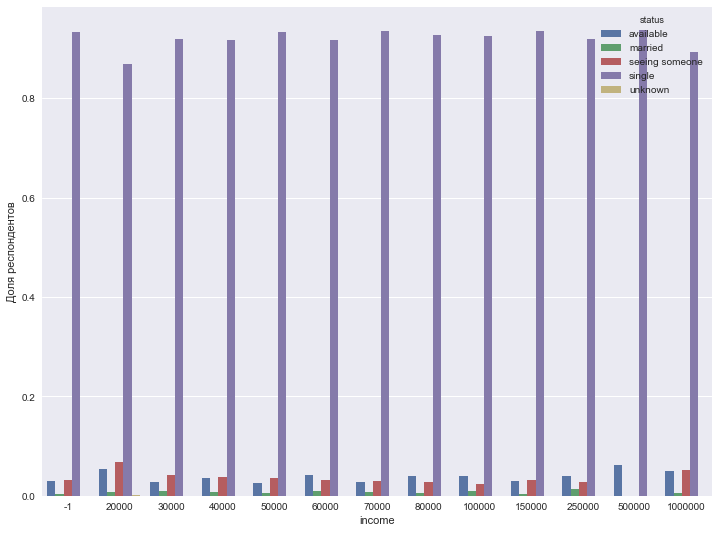

In [194]:
ct = pd.crosstab(data['income'], data['status'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T

stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Доля респондентов'})
sns.barplot(x=stacked['income'], y=stacked['Доля респондентов'], hue=stacked['status']);

Кажется доход совсем не влияет на счастье в личной жизни. А как насчет телосложения?

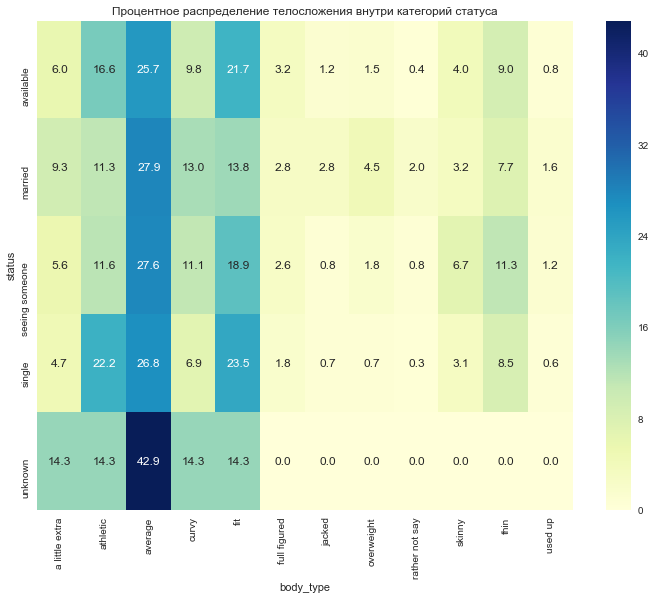

In [195]:
ct = pd.crosstab(data['body_type'], data['status'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (12,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Процентное распределение телосложения внутри категорий статуса');

Как видим - большинство респондентов - "среднего телосложения" :). Те кто состоит в браке не меньше следит за поддержанием формы, и среди них ощутимо больше процент людей с лишним весом. 
Посмотрим теперь на целевой признак, его распределение

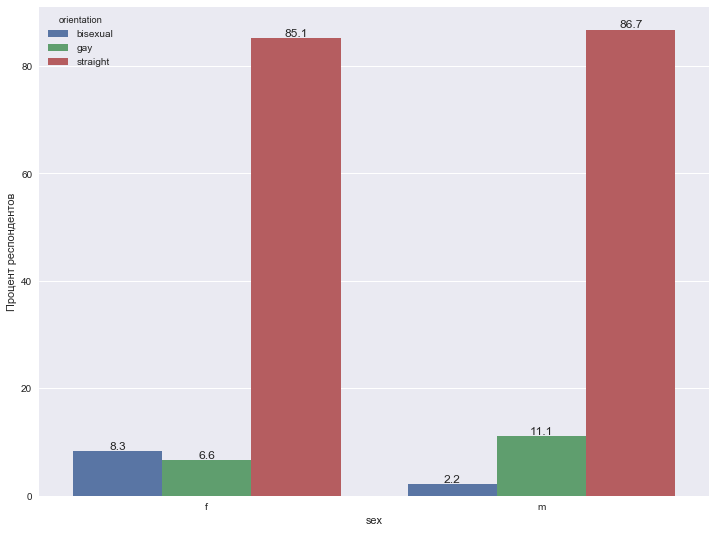

In [196]:
ct = pd.crosstab(data['sex'], data['orientation'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100

fig, ax = plt.subplots(1,1)
stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Процент респондентов'})
sns.barplot(x=stacked['sex'], y=stacked['Процент респондентов'], hue=stacked['orientation'], ax=ax);

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{0:.1f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom');

Как видно гетеросексуальных мужчин и женщин приблизительно по 85%, но женщины нетрадиционной сексуальной ориентации предпочитают бисексуальность в то время как мужчины в основном - строго гомосексуальны.
Еще один стереотип - среди богатых много людей нетрадиционной сексуальной ориентации. Проверим это

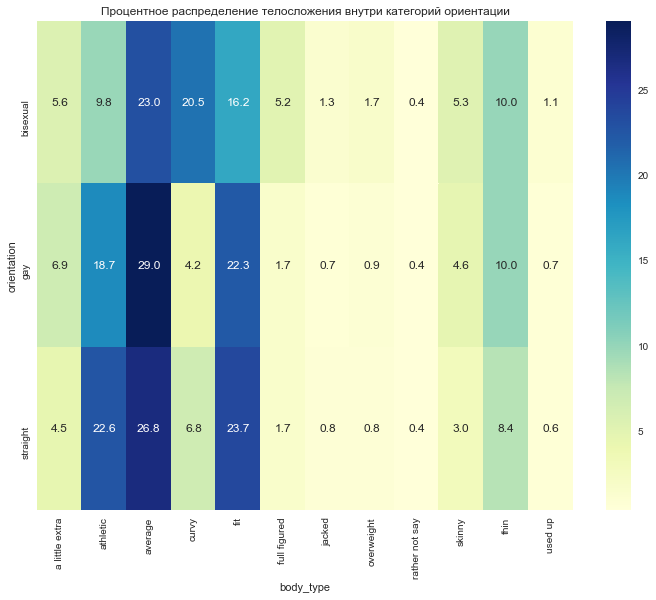

In [197]:
ct = pd.crosstab(data['body_type'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (12,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Процентное распределение телосложения внутри категорий ориентации');

Бисексуальные респонденты похоже значительно "фигуристей" остальных - выглядит как хороший признак. В то время как между геями и гетеросексуальными - особой разницы в теслосложении не наблюдается

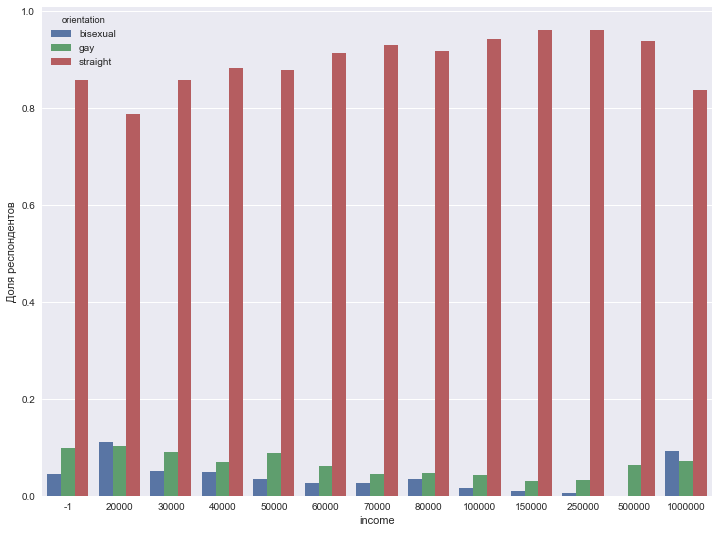

In [198]:
ct = pd.crosstab(data['income'], data['orientation'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T

stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Доля респондентов'})
sns.barplot(x=stacked['income'], y=stacked['Доля респондентов'], hue=stacked['orientation']);

Частично миф подтвержден :) тем не менее среди людей с нихким доходом ЛГБТ все таки еще больше.

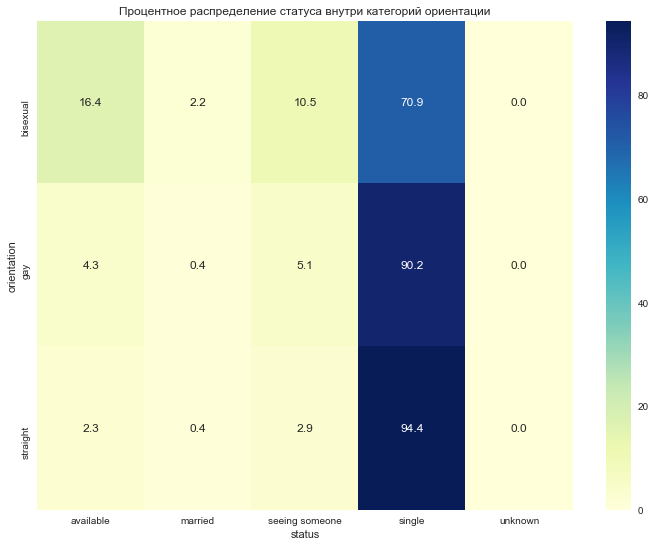

In [199]:
ct = pd.crosstab(data['status'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Процентное распределение статуса внутри категорий ориентации');

Бисексуалы значительно реже холосты, чем остальные. Вероятно это связано с природой бисексуальности - есть мотивация пользоваться сайтом знакомств даже при наличии партнера.
Мне нравятся бисексуалы - похоже их искать будет сравнительно просто.
Проверим нашу изначальную гипотезу о том что среди выбросов будет много таргета.

In [200]:
# data['height'].quantile(0.995)*2.45
print("Самый высокий и низкий респондент", int(data['height'].max()*2.45), "см и", int(data['height'].min()*2.45), "см")

Самый высокий и низкий респондент 232 см и 2 см


In [201]:
oldest_non_outlier = data['age'].quantile(0.995)
smallest_non_outlier = data['height'].quantile(0.005)
tallest_non_outlier = data['height'].quantile(0.995)
print(oldest_non_outlier, 'лет - еще выглядит правдоподобно. Используем как максимальный "не выброс"')
print("Самый высокий и низкий респондент", int(data['height'].min()*2.45), "см и", int(data['height'].max()*2.45), "см")
print("Возьмем пол перцентиля сверху и снизу по росту", int(smallest_non_outlier*2.45), "см и", int(tallest_non_outlier*2.45), "см")
outliers = data[data['height'].isnull() | 
                (data['age']>oldest_non_outlier) | 
                (data['height']<smallest_non_outlier) | 
                (data['height']>tallest_non_outlier)]
print("Колличество выбросов", outliers.shape[0], "из них %.1f%% таргета"%((outliers['orientation']!='straight').sum()*100/outliers.shape[0]))

65.0 лет - еще выглядит правдоподобно. Используем как максимальный "не выброс"
Самый высокий и низкий респондент 2 см и 232 см
Возьмем пол перцентиля сверху и снизу по росту 144 см и 188 см
Колличество выбросов 681 из них 9.4% таргета


Согласно википедии карлики бывают ростом меньше 147см, 144 - вполне реалистично. 188 так же выглядит здраво. А вот предположение о выбросах не подтвердилось.
В некоторых религиях ЛГБТ под запретом. Посмотрим распределение среди религий и среди серьезности отношения к религии

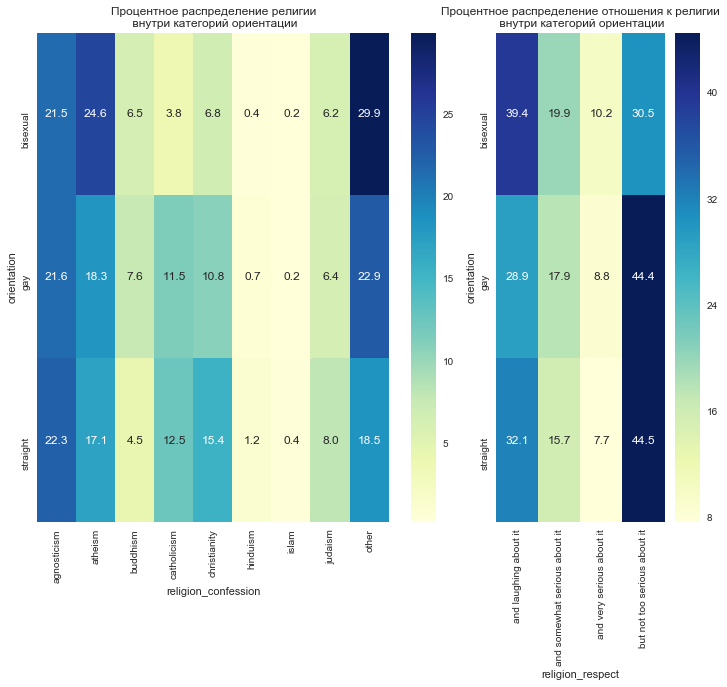

In [202]:
ct = pd.crosstab(data['religion_confession'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (9,1)).T*100

# f, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot2grid((1,6),(0,0), colspan=4)

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Процентное распределение религии\n внутри категорий ориентации');

ax2 = plt.subplot2grid((1,6),(0,4), colspan=2, sharey=ax1)
ct = pd.crosstab(data['religion_respect'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (4,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Процентное распределение отношения к религии\n внутри категорий ориентации');

Среди атеистов, и тех кто находит тему религии смешной значимо больше бисексуалов (шах и мат, аметисты xD). У ЛГБТ значимо меньше представителей аврамических религий, видимо церковь имеет свое влияние. Среди геев этот тренд наблюдается не так сильно как среди би. К сожалению геи слабо выделяются:(
Смотрим отношение к наркотикам и алкоголю, сигаретам и диетам

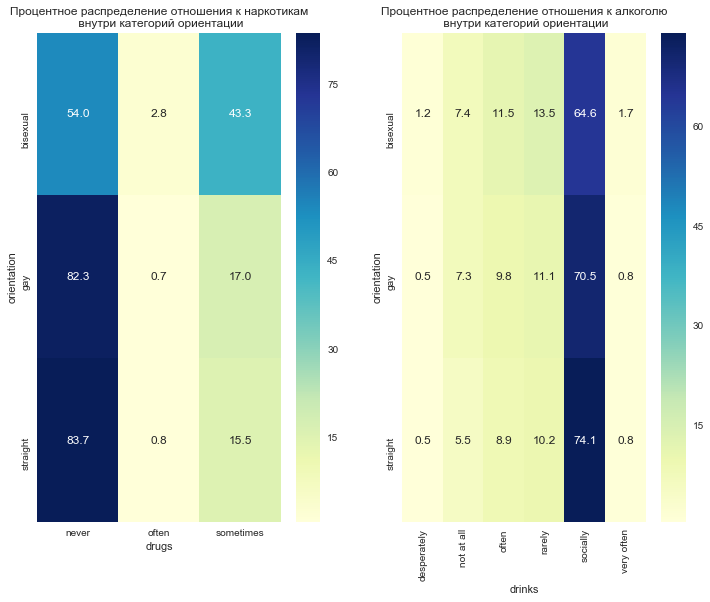

In [203]:
f, (ax1, ax2) = plt.subplots(1, 2)
ct = pd.crosstab(data['drugs'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Процентное распределение отношения к наркотикам\n внутри категорий ориентации');

ct = pd.crosstab(data['drinks'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (6,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Процентное распределение отношения к алкоголю\n внутри категорий ориентации');


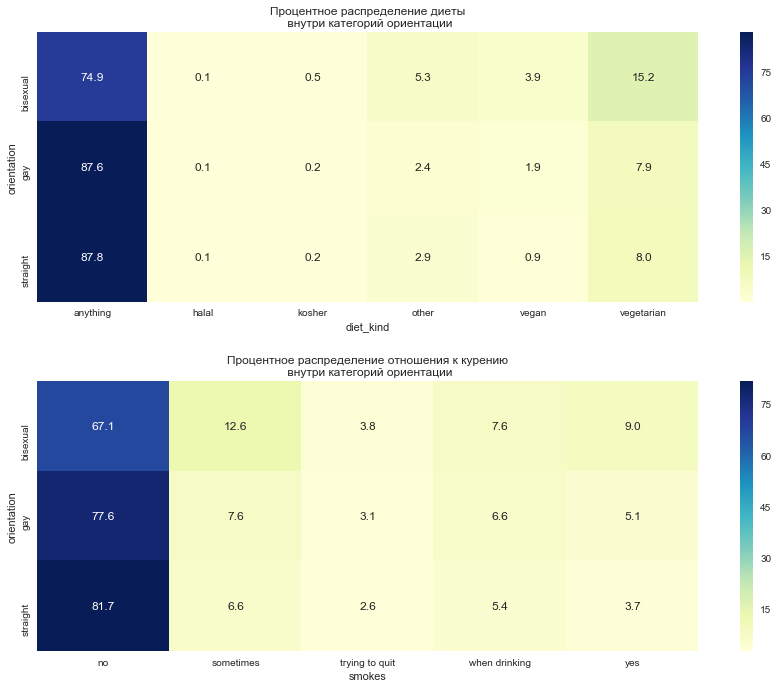

In [204]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.tight_layout(pad=0.4, w_pad=4.5, h_pad=5)

ct = pd.crosstab(data['diet_kind'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (6,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Процентное распределение диеты\n внутри категорий ориентации');

ct = pd.crosstab(data['smokes'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Процентное распределение отношения к курению\n внутри категорий ориентации');

Ну что ж - видно что бисексуалы имеют терпимое отношение к наркотикам, больше курят и ограничивают себя диетами. Кажется в признаках нет особого отличия для геев, просто на них корреляция слабее. 

Попробуем поискать корреляцию среди звезд - проверим как распредиляется ориентация среди разных знаков зодиака и отношения к астрологии :)

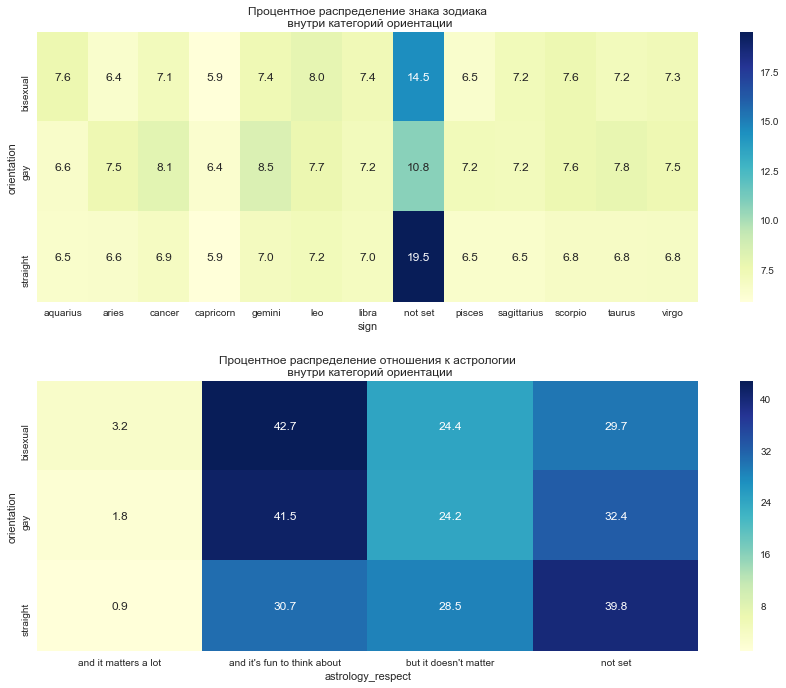

In [205]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.tight_layout(pad=0.4, w_pad=4.5, h_pad=5)

ct = pd.crosstab(data['sign'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (13,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Процентное распределение знака зодиака\n внутри категорий ориентации');

data['astrology_respect'] = data['astrology_respect'].str.replace('&rsquo;',"'")

ct = pd.crosstab(data['astrology_respect'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (4,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Процентное распределение отношения к астрологии\n внутри категорий ориентации');

Наконец то гомосексуалисты отличились от би - они гораздо реже оставляют поле знака зодиака не заполненым :) А еще если вы рак (или весы) то у вас выше шанс быть геем. _Я не хочу обидить любителей астрологии, но мне кажется что на самом деле зависимость ориентации от знака зодиака абсолютно нулевая, и мы имеем дело с ложной корреляцией_

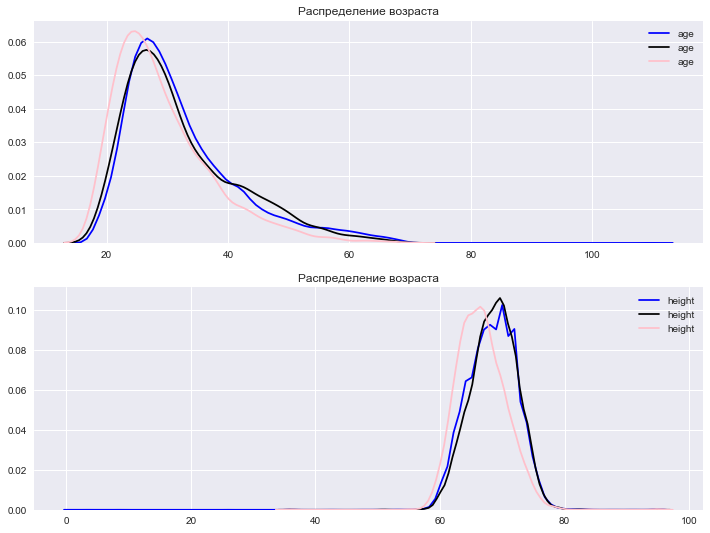

In [206]:
f, (ax1, ax2) = plt.subplots(2, 1)

sns.kdeplot(data[data['orientation'] == 'straight']['age'], color='blue', ax=ax1).set_title('Распределение возраста')
sns.kdeplot(data[data['orientation'] == 'gay']['age'], color='black', ax=ax1);
sns.kdeplot(data[data['orientation'] == 'bisexual']['age'], color='pink', ax=ax1);
sns.kdeplot(data[data['orientation'] == 'straight']['height'].dropna(), color='blue', ax=ax2).set_title('Распределение возраста')
sns.kdeplot(data[data['orientation'] == 'gay']['height'].dropna(), color='black', ax=ax2);
sns.kdeplot(data[data['orientation'] == 'bisexual']['height'].dropna(), color='pink', ax=ax2);

Похоже в росте и возрасте нет никакой зависимости, и все отклонения связаны с тем что би - в основному женщины а гие - мужчины

###  Часть 4. Закономерности, "инсайты", особенности данных

В большинстве своем даные выглядят очень хорошо, выбросов не так много, но и особых закономерностей о гомосексуалистах не видно. Зато бисексуалы достаточно отличаются. Есть зависимости в отношении к религиозной, социальной этике и спорту, некоторые другие зависимости, но внушает опасение тот факт что обычно геи и би имеют одинаковую зависимость от признака, но в разной степени - возможно их будет довольно сложно различать.

Особенностью даных есть некая "текстовость" - много категориальных признаков склеены в один. Есть целых 10 текстовых полей, много из них не заполнены. А чисельных признаков практически нет.

###  Часть 5. Предобработка данных 

Большую часть предобработки даных мы уже сделали по ходу рассмотрения. Сейчас заполним пробелы и разобъем мультикатегориальные признаки на много бинарных

In [207]:
# Посмотрим уникальные рассовые признаки. 
import re
data['ethnicity'].fillna('not set', inplace=True)
ethnicities = set()
data['ethnicity'].str.split(', ').apply(lambda x: ethnicities.update(x));
ethnicities 

{'asian',
 'black',
 'hispanic / latin',
 'indian',
 'middle eastern',
 'native american',
 'not set',
 'other',
 'pacific islander',
 'white'}

In [208]:
for e in ethnicities:
  data['ethnicity_' + e] = data['ethnicity'].str.contains(re.escape(e))
#   Проделаем аналогичную обработку с языками

In [209]:
data['speaks'].fillna('not set', inplace=True)
langs = set()
data['speaks'].str.split(', ').apply(lambda x: langs.update(x));
for l in langs:
  data['speaks_' + l] = data['speaks'].str.contains(re.escape(l))

In [210]:
data[list(filter(lambda x: 
                 not x.startswith('speaks_') and 
                 not x.startswith('ethnicity_') and 
                 not x.startswith('essay'), data.columns))].count()

age                    59946
body_type              54650
diet                   35551
drinks                 56961
drugs                  45866
education              53318
ethnicity              59946
height                 59943
income                 59946
job                    51748
last_online            59946
location               59946
offspring              24385
orientation            59946
pets                   59946
religion               39720
sex                    59946
sign                   59946
smokes                 54434
speaks                 59946
status                 59946
diet_kind              59946
diet_strenght          59946
religion_confession    39720
religion_respect       27939
has_kids               59946
want_kids              59946
astrology_respect      59946
cats_relation          59946
dogs_relation          59946
dtype: int64

In [211]:
# Заполним пропуски модой для тех признаков которые почти полностью заполнены
data['body_type'].fillna(data['body_type'].mode().values[0], inplace=True)
data['drinks'].fillna(data['drinks'].mode().values[0], inplace=True)
data['smokes'].fillna(data['smokes'].mode().values[0], inplace=True)

# education и job слишком сложные, оставим вместе с остальными 'not set'

data['education'].fillna('not set', inplace=True)
data['job'].fillna('not set', inplace=True)
data['drugs'].fillna('not set', inplace=True)
data['religion_confession'].fillna('not set', inplace=True)
data['religion_respect'].fillna('not set', inplace=True)

# выбросы вряд ли значат что человек который их заполнял ошибся на пару лет или дюймов - 
# в данном случае вернее будет заполнить даные медианными значениями
data['height'].fillna(data['height'].median(), inplace=True)
data['height'][data['height']>tallest_non_outlier] = data['height'].median()
data['height'][data['height']<smallest_non_outlier] = data['height'].median()
data['age'][data['age']>oldest_non_outlier] = data['age'].median()

outliers = data[data['height'].isnull() | 
                (data['age']>oldest_non_outlier) | 
                (data['height']<smallest_non_outlier) | 
                (data['height']>tallest_non_outlier)]
outliers.shape[0]

0

###  Часть 6. Создание новых признаков и описание этого процесса

Большая часть признаков либо категориальные либо бинарные(тоже категориальные но multilabel), но есть текст. Текст проще всего превратить в Tf-idf - будет sparse-матрица. Лучше всего справляется с категориальными признаками CatBoost, но он не работает с sparse-признаками, в которые мы можем превратить текст. Если применить к категориальным признакам One Hot Encoding - получится достаточно большая разреженая матрица. Деревянные методы не очень хорошо работают на таких даных(Учитывая tf-idf матрицу). Вероятно лучше всего взять в качестве бейслайн модели - логистическую регрессию. Линейные модели хорошо показывают себя на подобного рода признаках, и быстро обучаются, что удобно для эксперементов.
После получения первого бейзлайна - попробуем превратить текст в doc2vec вектор, что снизит размерность до приемлимого уровня, и он больше не будет sparse - если существенной потери качества не будет - попробуем обучить CatBoost на категориях+doc2vec.
Бустинг достаточно сложно использовать для тестирования фичей из-за обилия гиперпараметров и долгого обучения. Возможно нейронная сеть справилась бы с задачей точнее, и даже могла бы сама себе сделать doc2vec, но ~60k примеров - для нейронной сети может быть недостаточно(для обучения собственного doc2vec с нуля - совсем не достаточно. Для обучения нейронных сетей задачам nlp используются огромные корпуса текста по 1B слов). Кроме того - у нейронной сети очень короткое плато обучения. Переобучение наступает довольно быстро и часто незаметно, а характер обучения неудобен для многофолдовой крос-валидации.

Подитожим создание признаков:
- tf-idf всего текста
- doc2vec текста
- OHE категориальных фич для бейслайн модели

Клеим все essay в один и убираем разметку

In [44]:
essay = data[list(filter(lambda x: x.startswith('essay'), data.columns))].fillna(' ').replace('\n|\t',' ', regex=True)
essay.to_csv('tmp_essay.csv', sep=' ', quotechar=' ',
                       index=None, header=None)
essay = pd.read_csv('tmp_essay.csv', sep='\t', skip_blank_lines=False, quotechar='\t', header=None)
essay = essay[0].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [88]:
le = LabelEncoder()
y = le.fit_transform(data['orientation'])
le.classes_

array(['gay', 'straight', 'bisexual'], dtype=object)

###  Часть 7. Кросс-валидация, подбор параметров

Временной зависимости в данных нет, но есть дизбаланс классов, поэтому валидироваться лучше на **StratifiedKFold**.
На отложеную выборку уйдет 25%, остальное - 3-fold crossvalidation. На кросвалидации будем смотреть на полноту, если она растет выше дизбаланса в классах - посмотрим AUC.

In [90]:
to_drop = ['diet', 'pets', 'speaks', 'religion', 'last_online',
           'offspring', 'ethnicity', *filter(lambda x: x.startswith('essay'), data.columns)]

data_train, data_test, essay_train, essay_test, y_train, y_test = \
  train_test_split(data.drop(columns=to_drop), essay, y, test_size=0.25, random_state=42)

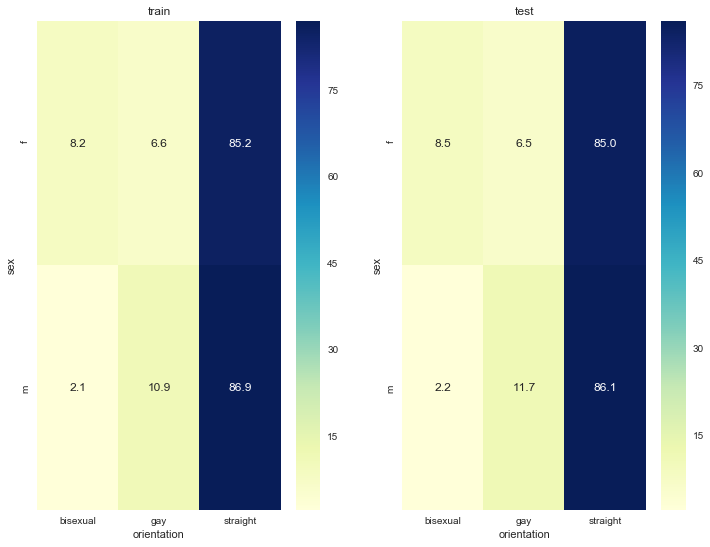

In [212]:
_, (ax1, ax2) = plt.subplots(1,2)

ct = pd.crosstab(data_train['orientation'], data_train['sex'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1).set_title('train');

ct = pd.crosstab(data_test['orientation'], data_test['sex'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2).set_title('test');

# Check the distributions

In [48]:
%%time
tfidf = TfidfVectorizer()
essay_train_tfidf, essay_test_tfidf = tfidf.fit_transform(essay_train), tfidf.transform(essay_test)

Wall time: 31.1 s


Текстовые даные в tf-idf формате есть. Теперь отмасштабируем чисельные фичи, и получим OHE с категориальных

In [49]:
scale_features = ['age', 'height']
scaler = StandardScaler()
scaled_train, scaled_test = scaler.fit_transform(data_train[scale_features]), \
                                scaler.transform(data_test[scale_features])

In [50]:
def transform_label_encode(df_train, df_test, field):
  le = LabelEncoder()
  full_labled = pd.concat([df_train[field], df_test[field]])
  full_labled = le.fit_transform(full_labled)
  train_labled, test_labled = full_labled[:df_train.shape[0]], full_labled[df_train.shape[0]:]

  ohe = OneHotEncoder(handle_unknown='ignore')
  train_labled, test_labled = ohe.fit_transform(train_labled[:, np.newaxis]), ohe.transform(test_labled[:, np.newaxis])
  return train_labled, test_labled
# def transform_label_encode(df_train, df_test, field):
#   lb = LabelBinarizer(sparse_output=True)
#   return lb.fit_transform(df_train[field]), lb.transform(df_test[field])

cat_features = ['body_type', 'drinks', 'drugs', 'education', 'income',
               'job', 'location', 'sex', 'sign', 'smokes', 'status',
               'diet_kind', 'diet_strenght', 'religion_confession', 'religion_respect',
               'has_kids', 'want_kids', 'astrology_respect', 'cats_relation',
               'dogs_relation']
ohe_train, ohe_test = zip(*[transform_label_encode(data_train, data_test, f) for f in cat_features])

bin_features = [*filter(lambda x : x.startswith('speaks_') or x.startswith('ethnicity_'), data_train.columns)]
bina_train, bina_test = data_train[bin_features].astype(float).values, data_test[bin_features].astype(float).values

Склеим все вместе, и получим огромную разреженую матрицу

In [111]:
X_train = csr_matrix(hstack([scaled_train, bina_train, *ohe_train, essay_train_tfidf]))
X_test = csr_matrix(hstack([scaled_test, bina_test, *ohe_test, essay_test_tfidf]))

Теперь сделаем из текста doc2vec, нам поможет pretrained модель из tensorflow-hub:

In [52]:
def maybe_make_embeddings(text_train, text_test):
  if os.path.exists('embedding_essay_train.txt') and os.path.exists('embedding_essay_test.txt'):
    embedding_out_train = np.loadtxt('embedding_essay_train.txt')
    embedding_out_test =  np.loadtxt('embedding_essay_test.txt')
    return embedding_out_train, embedding_out_test
  tf.logging.set_verbosity(tf.logging.WARN)
  tf.reset_default_graph() 
  graph = tf.Graph()
  with tf.device('/gpu:0'), graph.as_default():
    tf_X_content = tf.placeholder(tf.string, shape=(None))
    embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")
    embedding_op = embed(tf_X_content)
    
  embedding_out_train = []
  embedding_out_test = []
  batch_size=500

  def text_2_embed(X, start):
    embedding_out = []
    max_idx = X.shape[0]
    for i in range(0, max_idx, batch_size):
      end_idx = i+batch_size
      embedding_out.append(session.run(embedding_op, feed_dict={
        tf_X_content:X[i:i+batch_size]
      }))
      if i%5000 == 0:
        print("%.1fs passed, i: %d of %d" % (time.time() - start, i, max_idx) )

    return embedding_out

  start = time.time()

  with tf.Session(graph=graph) as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    print('Initialized')
    print("%.1fs passed" % (time.time() - start) )

    embedding_out_train = text_2_embed(text_train.values, start)
    embedding_out_test = text_2_embed(text_test.values, start)
    
  embedding_out_train, embedding_out_test = np.concatenate(embedding_out_train), np.concatenate(embedding_out_test)
    
  np.savetxt('embedding_essay_train.txt', embedding_out_train)
  np.savetxt('embedding_essay_test.txt', embedding_out_test)
  tf.reset_default_graph() 
  return embedding_out_train, embedding_out_test


In [53]:
d2v_train, d2v_test = maybe_make_embeddings(essay_train, essay_test)

In [214]:
logit = LogisticRegression(random_state=17, multi_class='multinomial', solver='lbfgs')
scorer=make_scorer(recall_score, average='micro')
skf = StratifiedKFold(y_train)
cross_val_score(logit, X_train, y_train, scoring=scorer, cv=skf)

array([0.88350681, 0.88275724, 0.88081415])

Из коробки точность ~0.88. Похоже это из-за разбалансировки классов. Попробуем подстроить параметр регуляризации

###  Часть 8. Построение кривых валидации и обучения 

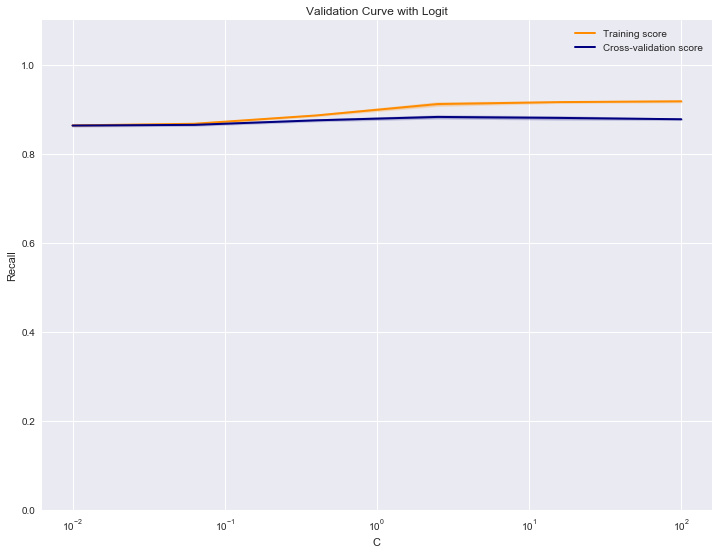

In [217]:
param_range = np.logspace(-2, 2, 6)
train_scores, test_scores = validation_curve(
    logit, X_train, y_train, param_name="C", param_range=param_range,
    cv=skf, scoring=scorer, n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logit")
plt.xlabel("C")
plt.ylabel("Recall")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Похоже что регуляризация в нашем случае минимально влияет на полноту

[learning_curve] Training set sizes: [ 2997  9740 16484 23227 29971]


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  6.4min finished


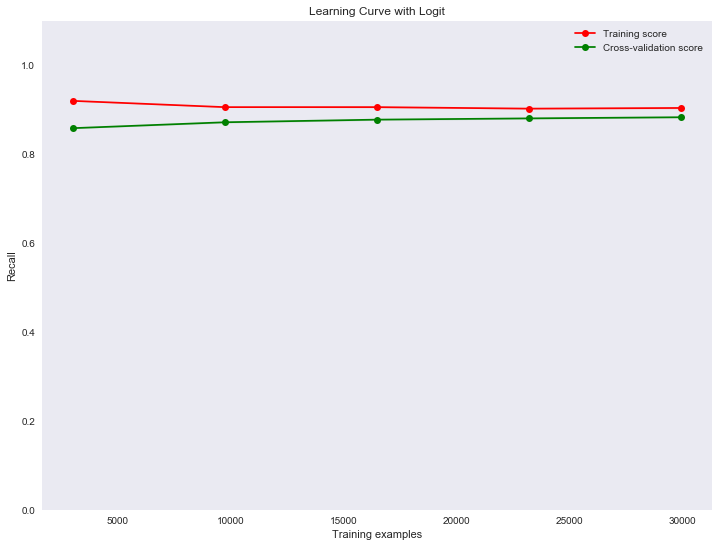

In [216]:
plt.figure()
plt.title('Learning Curve with Logit')
plt.ylim(0.0, 1.1)
plt.xlabel("Training examples")
plt.ylabel("Recall")
train_sizes, train_scores, test_scores = learning_curve(
  logit, X_train, y_train, scoring=scorer,
#   cv=skf, 
  n_jobs=2, verbose=1, random_state=17)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best");

К сожалению увеличение колличества примеров не покажет роста производительности - мы уже впритык подобрались к близжайшей точке между трейном и валидейшном

In [151]:
X_train_cb = np.concatenate([data_train[[*bin_features, *cat_features]].values, scaled_train, d2v_train], axis=1)
X_test_cb = np.concatenate([data_test[[*bin_features, *cat_features]].values, scaled_test, d2v_test], axis=1)

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_cb, y_train, test_size=0.25, random_state=42)

In [152]:
cat_idx = len(bin_features) + len(cat_features)
D_train = catboost.Pool(X_train_part, y_train_part, cat_features=list(range(cat_idx)))
D_val = catboost.Pool(X_valid, y_valid, cat_features=list(range(cat_idx)))
D_test = catboost.Pool(X_test_cb, cat_features=list(range(cat_idx)))

In [ ]:
params = dict()
params['learning_rate'] = 0.01
params['depth'] = 8
params['l2_leaf_reg'] = 1
params['rsm'] = .5
model = catboost.CatBoostClassifier(iterations=500,
                                    learning_rate=params['learning_rate'],
                                    depth=int(params['depth']),
                                    loss_function='MultiClass',
                                    use_best_model=True,
                                    eval_metric='AUC',
#                                     task_type='GPU',
                                    random_seed=17,
                                    colsample_bylevel=0.7,
                                    od_type='IncToDec',
                                    od_pval=1e-3,
                                    od_wait=20,
                                    verbose=False
                                    )
model.fit(D_train, eval_set=D_val, verbose=True)

_CatBoost очень странно работает для мультиклассовой классификации, ни одна eval__metric кроме AUC в целом не показывает значений отличных от 0_

###  Часть 9. Прогноз для тестовой или отложенной выборки

In [143]:
predict = model.predict_proba(D_test)
classes = model.predict(D_test)
print('Accuracy is %.3f' % accuracy_score(y_test, classes))
print('Category\tAUC\tAccuracy')
for i in range(3):
  y_cls = y_test == i
  print("%8s\t%.3f\t%.3f"%(le.classes_[i], roc_auc_score(y_cls, predict[:,i]), accuracy_score(y_cls, classes == i)))

Accuracy is 0.872
Category	AUC	Accuracy
bisexual	0.877	0.954
     gay	0.833	0.913
straight	0.838	0.878


In [224]:
logit = LogisticRegression(random_state=17, C=6)
logit.fit(X_train, y_train)
predict = logit.predict_proba(X_test)
classes = logit.predict(X_test)
print('Accuracy is %.3f' % accuracy_score(y_test, classes))
print('Category\tAUC\tAccuracy')
for i in range(3):
  y_cls = y_test == i
  print("%8s\t%.3f\t%.3f"%(le.classes_[i], roc_auc_score(y_cls, predict[:,i]), accuracy_score(y_cls, classes == i)))

Accuracy is 0.889
Category	AUC	Accuracy
bisexual	0.875	0.954
     gay	0.878	0.929
straight	0.875	0.895


###  Часть 10. Оценка модели с описанием выбранной метрики

Не смотря на все старания в подборе гиперпараметров CatBoost - линейная модель имеет преимущества в работе с разрежеными данными. ROC_AUC логистической регрессии оказался существенно выше, а тренировка - проще. ROC_AUC сглаживает ситуацию несбалансированости классов, но даже если взять просто процент правильно классифицированных примеров то логит справился лучше.

### Часть 11. Выводы 

Линейные модели, и логистическая регрессия в частности показывают хороший бейзлайн в задаче классификации, отлично работают с разрежеными данными и легко настраивается. К сожалению идея использования CatBoost не сработала - то ли текст признаков essay слишком удобно ложится в tfidf, то ли я просто не смог подобрать гиперпараметры. Имея в распоряжении значительно больше примеров - можно было бы построить нейросетевую модеть - она может работать не хуже логистической регрессии, но обучается сложнее.